# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_arr = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        
        return 1 / (1 + np.exp(-np.dot(X, weights)))
        
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        temp_sum = 0
        for i in range(len(y)):
            temp_sum +=  np.log(1 + np.exp(-np.dot(self.weights_, x[i]) * y[i])) 
        return temp_sum * 1 / x.shape[0] + 1 / (2 * self.C)*np.linalg.norm(weights)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            temp_sum=0
            for j in range(X_ext.shape[0]):
                temp_sum += y[j] * X_ext[j] * (1 - 1 / (1 + np.exp(-np.dot(self.weights_, X_ext[j]) * y[j])))
            delta = -(temp_sum / X_ext.shape[0] - 1 / self.C * self.weights_)
            self.weights_ -= self.eta * delta
            self.loss_arr.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        proba = self.predict_proba(X)
        return np.array([1 if el > 0.5 else -1 for el in proba])

In [5]:
from sklearn import datasets
from sklearn import metrics

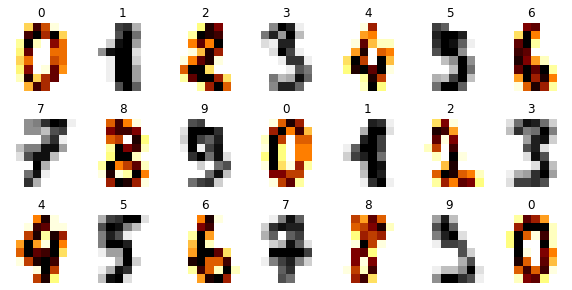

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [24]:
lr_clf.fit(X_train, y_train)

In [25]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [26]:
model = CustomLogisticRegression()

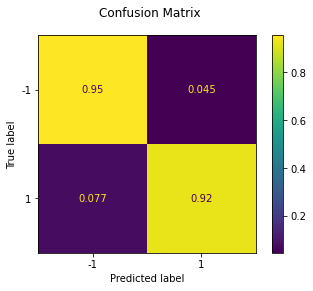

In [27]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [28]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [29]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

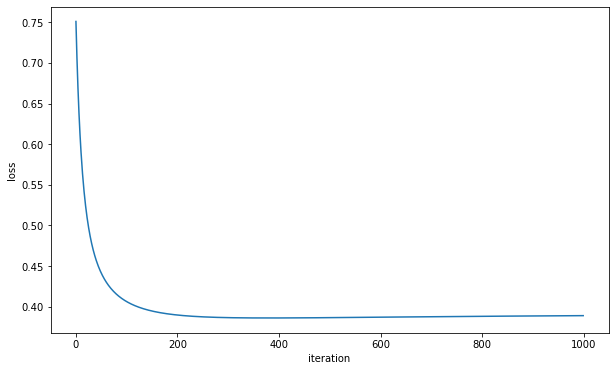

In [30]:
plt.figure(figsize=[10, 6])
plt.plot([i for i in range(len(model.loss_arr))], model.loss_arr)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [31]:
def train_test_acc_plot(frame, train_arr, test_arr, xlabel, label1='train_acc', label2='test_acc'):
    plt.figure(figsize=[10, 6])
    plt.plot(frame, train_arr, label=label1)
    plt.plot(frame, test_arr, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel('acc')
    plt.legend()
    plt.show()

In [32]:
train_acc_arr, test_acc_arr = [], []
frame = np.arange(0.001, 0.03, 0.002)
for el in frame:
    model = CustomLogisticRegression(eta=el)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)

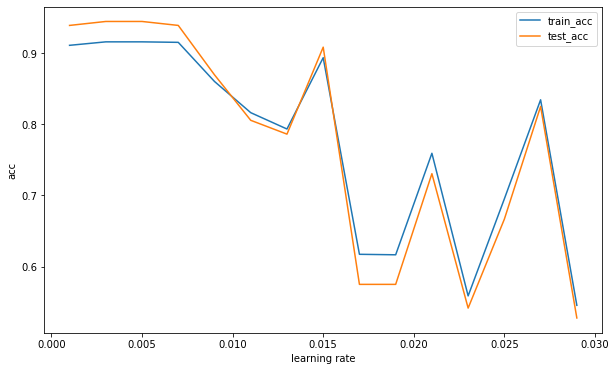

In [33]:
train_test_acc_plot(frame, train_acc_arr, test_acc_arr, xlabel='learning rate')

The optimal learning rate in this task is about 0.004.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [34]:
train_acc_arr, test_acc_arr = [], []
frame = np.arange(0.1, 1.1, 0.1)
for el in frame:
    model = CustomLogisticRegression(C=el)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    train_acc_arr.append(train_acc)
    test_acc_arr.append(test_acc)

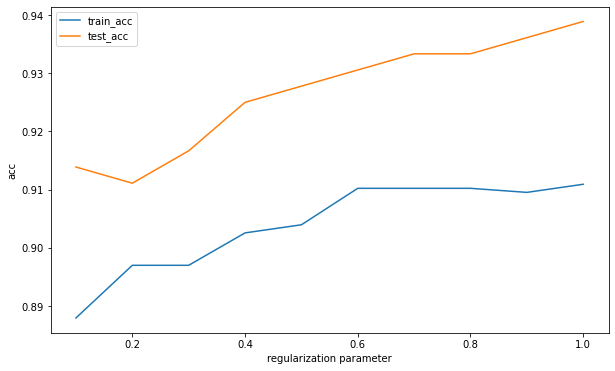

In [35]:
train_test_acc_plot(frame, train_acc_arr, test_acc_arr, xlabel='regularization parameter')

**(0.5 points)** Compare zero initialization and random initialization. 

In [36]:
for el in np.arange(0.001, 0.02, 0.002):
    model = CustomLogisticRegression(eta=el, zero_init=True)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print(train_acc, test_acc)

0.9116214335421016 0.9388888888888889
0.9157967988865693 0.9444444444444444
0.9157967988865693 0.9444444444444444
0.9144050104384134 0.9444444444444444
0.8503827418232429 0.8361111111111111
0.8733472512178149 0.875
0.8684759916492694 0.875
0.8851774530271399 0.8833333333333333
0.7745302713987474 0.7666666666666667
0.5664578983994433 0.575


In [37]:
train_acc, test_acc

(0.5664578983994433, 0.575)

In [38]:
for el in np.arange(0.001, 0.02, 0.002):
    model = CustomLogisticRegression(eta=el)
    model.fit(X_train, y_train)
    train_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print(train_acc, test_acc)

0.9109255393180237 0.9388888888888889
0.9157967988865693 0.9444444444444444
0.9157967988865693 0.9444444444444444
0.9151009046624913 0.9388888888888889
0.860125260960334 0.8694444444444445
0.8162839248434238 0.8055555555555556
0.7933194154488518 0.7861111111111111
0.8935281837160751 0.9083333333333333
0.6172581767571329 0.575
0.616562282533055 0.575


## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [11]:
from operator import itemgetter

In [275]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.zeros((X.shape[0], Y.shape[0]))
        for i in range(X.shape[0]):
            for j in range(Y.shape[0]):
                P[i, j] = np.linalg.norm(X[i] - Y[j])
        return P
        
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        class_dict = {el:[0, 0] for el in self.classes_}
        for i in range(len(y)):
            val = class_dict[y[i]]
            if val[0] == 0:
                class_dict[y[i]][0], class_dict[y[i]][1] = 1, weights[i]
            else:
                class_dict[y[i]][0] += 1
                class_dict[y[i]][1] += weights[i]
                
        p = [class_dict[el][1] for el in self.classes_]
        return p         
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1/(P + self.eps)
            y = []
            for i in range(P.shape[0]):
                indexes = P[i].argsort()[:self.n_neighbors]
                indexes = self.get_class_weights(itemgetter(indexes)(self.y), itemgetter(indexes)(weights_of_points[i]))
                indexes = [el / sum(indexes) for el in indexes]
                y.append(indexes)
            return np.array(y)
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y = self.predict_proba(X) 
        return [np.argmax(el) for el in y]

In [276]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [277]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [278]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

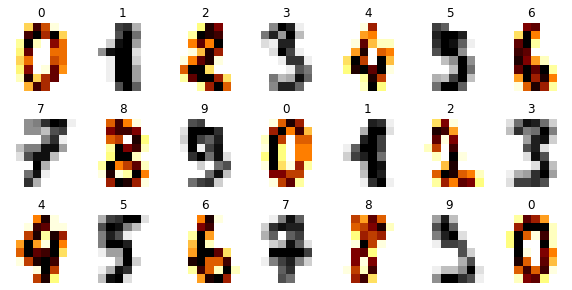

In [279]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [280]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [281]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

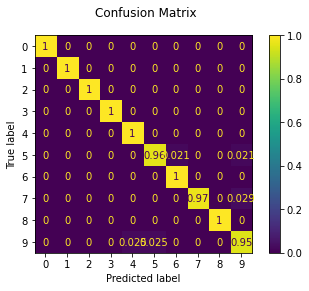

In [282]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [283]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

According to the confusion matrix, the number 5 is confused with 6 and 9, the number 7 is confused with 9, the number 9 is confused with 4 and 5. This is because of the similar shape of these numbers in the dataset.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [258]:
for el in np.concatenate((np.arange(3, 10, 1), np.arange(11, 20, 2))):
    model = CustomKNeighborsClassifier(n_neighbors=el, weights='distance')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print('k ==', el, ':', test_acc)

k == 3 : 0.9833333333333333
k == 4 : 0.9833333333333333
k == 5 : 0.9861111111111112
k == 6 : 0.9888888888888889
k == 7 : 0.9888888888888889
k == 8 : 0.9861111111111112
k == 9 : 0.9805555555555555
k == 11 : 0.9833333333333333
k == 13 : 0.9777777777777777
k == 15 : 0.9805555555555555
k == 17 : 0.9833333333333333
k == 19 : 0.975


The best k for this dateset is 5 or 6.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [265]:
for el in np.arange(3, 20, 4):
    model = CustomKNeighborsClassifier(n_neighbors=el, weights='distance')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    model = CustomKNeighborsClassifier(n_neighbors=el, weights='uniform')
    model.fit(X_train, y_train)
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    print('k ==', el, ':', 'distance_weight', test_acc)
    print('k ==', el, ':', 'uniform_weight', test_acc)

k == 3 : distance_weight 0.9833333333333333
k == 3 : uniform_weight 0.9833333333333333
k == 7 : distance_weight 0.9888888888888889
k == 7 : uniform_weight 0.9888888888888889
k == 11 : distance_weight 0.9833333333333333
k == 11 : uniform_weight 0.9833333333333333
k == 15 : distance_weight 0.9805555555555555
k == 15 : uniform_weight 0.9805555555555555
k == 19 : distance_weight 0.975
k == 19 : uniform_weight 0.975


Distance weighting is very useful for sparse data.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

In [289]:
for el in ['cityblock',
 'cosine',
 'euclidean',
 'l2',
 'l1',
 'manhattan',
 'nan_euclidean',
 'braycurtis',
 'canberra',
 'chebyshev',
 'correlation',
 'cosine',
 'dice',
 'hamming',
 'jaccard',
 'kulsinski',
 'matching',
 'minkowski',
 'rogerstanimoto',
 'russellrao',
 'seuclidean',
 'sokalmichener',
 'sokalsneath',
 'sqeuclidean',
 'yule']:
    try:
        model = KNeighborsClassifier(n_neighbors=6, weights='distance', metric=el)
        model.fit(X_train, y_train)
        test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
        print(el, ':', test_acc)
    except Exception as err:
        print(el, ':', err)

cityblock : 0.975
cosine : 0.9861111111111112
euclidean : 0.9888888888888889
l2 : 0.9888888888888889
l1 : 0.975
manhattan : 0.975
nan_euclidean : 0.9888888888888889
braycurtis : 0.9777777777777777
canberra : 0.9583333333333334
chebyshev : 0.9805555555555555
correlation : 0.9861111111111112
cosine : 0.9861111111111112
dice : 0.9083333333333333
hamming : 0.8777777777777778
jaccard : 0.9083333333333333
kulsinski : 0.9111111111111111
matching : 0.9166666666666666
minkowski : 0.9888888888888889
rogerstanimoto : 0.9166666666666666
russellrao : 0.7638888888888888
seuclidean : 0.09166666666666666
sokalmichener : 0.9166666666666666
sokalsneath : 0.9083333333333333
sqeuclidean : 0.9888888888888889
yule : 0.75


**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

If the objects are sets (for example, each object is a text represented
by a set of words), then their similarity can be measured using the Jaccard distance.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
titanic_data = pd.read_csv(os.path.join(PATH, 'train.csv')).set_index('PassengerId')
titanic_test_data = pd.read_csv(os.path.join(PATH, 'test.csv')).set_index('PassengerId')

In [5]:
titanic_data.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
12598,0,1,"Davis, Felicia",female,35.00,0,0,PC 326987,76.94,A9508,C
40803,0,3,"Edwards, Todd",male,41.00,0,1,195488,27.79,NaN,C
67459,0,3,"Mcglade, Jenny",female,0.58,1,2,509391,35.07,NaN,S
98913,1,1,"Lee, Heather",female,61.00,1,1,24979,224.41,B14522,C
69087,0,3,"Kramer, Todd",male,50.00,1,2,A/5 7337,31.06,NaN,S
60257,1,1,"Goard, Francis",female,5.00,2,0,27483,30.88,C9356,C
91365,0,3,"Griffen, Mark",male,51.00,0,0,STON/O 37655,11.09,NaN,S
51647,1,2,"Leavitt, Yoshiko",female,22.00,0,0,18170,27.00,NaN,S
98942,0,3,"Barnes, Donnie",male,51.00,0,0,STON/O 217914,11.37,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [293]:
titanic_data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

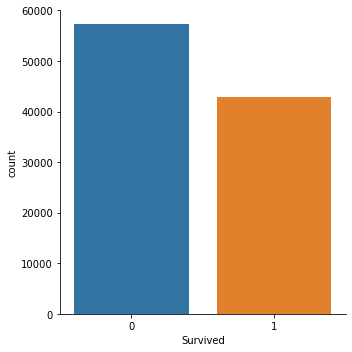

In [294]:
sns.catplot(x='Survived', kind='count', data=titanic_data)
plt.show()

In [295]:
print(1 - titanic_data.Survived.sum()/titanic_data.Survived.count())

0.57226


About 57% of passengers died. Let's see how the survival rate depends on the gender of the passenger.

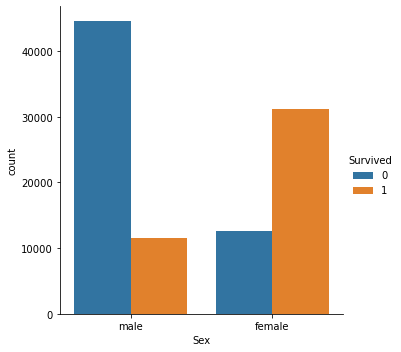

In [296]:
sns.catplot(x='Sex', hue='Survived', kind='count', data=titanic_data)
plt.show()

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

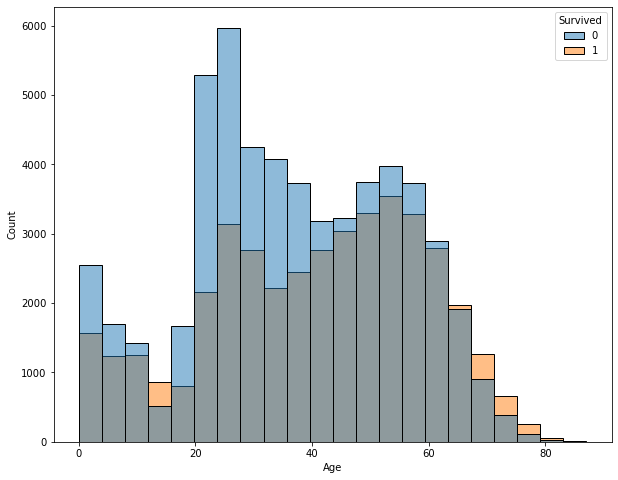

In [300]:
plt.figure(figsize=(10,8))
sns.histplot(x='Age', hue='Survived', data=titanic_data, bins=22)
plt.show()

In [321]:
titanic_data.groupby('Survived')['Age'].mean()

Survived
0    36.708695
1    40.553799
Name: Age, dtype: float64

In [322]:
titanic_data.groupby('Survived')['Age'].median()

Survived
0    36.0
1    43.0
Name: Age, dtype: float64

In [323]:
titanic_data.groupby('Sex')['Age'].median()

Sex
female    42.0
male      36.0
Name: Age, dtype: float64

The greatest difference in the number of survived and deceased passengers in the range from 20 to 40 years.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

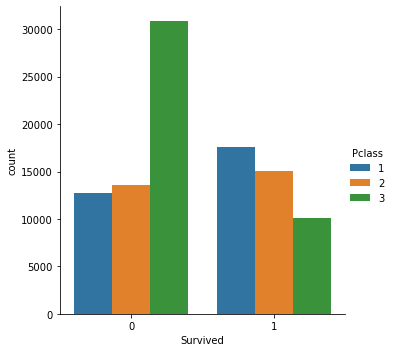

In [23]:
sns.catplot(x='Survived', hue='Pclass', kind='count', data=titanic_data)
plt.show()

In [24]:
pd.crosstab(titanic_data.Pclass, titanic_data.Survived, margins=True, normalize=False)

Survived,0,1,All
Pclass,,,
1,12739,17576,30315
2,13622,15057,28679
3,30865,10141,41006
All,57226,42774,100000


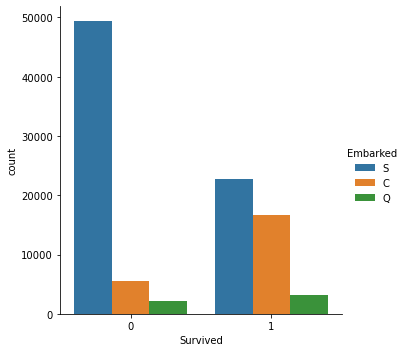

In [25]:
sns.catplot(x='Survived', hue='Embarked', kind='count', data=titanic_data)
plt.show()

In [26]:
pd.crosstab(titanic_data.Pclass, titanic_data.Embarked, margins=True, normalize=False)

Embarked,C,Q,S,All
Pclass,,,,
1,11843,3751,14635,30229
2,6156,844,21609,28609
3,4188,829,35895,40912
All,22187,5424,72139,99750


We see that the largest number of people were in Southampton, and most of them are in the 3rd class. Passengers who boarded in Cherbourg have a better chance of survival. Passengers from the 1st class have better chances to survive.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [27]:
titanic_data.shape[0]

100000

In [28]:
titanic_data.isnull().sum() / titanic_data.shape[0]*100

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Approaches to working with missing values:

1. Missing values in Age can be replaced by the median value.
2. Ticket is likely not to be significant for determining the chances of survival.
3. There are a lot of missing values in the Cabin column and also the location of the cabins on the ship is unknown, so it can be dropped.
4. Missing values in Embarked can be replaced by the mode.
5. Missing values in Fare can be replaced by the median value.

These approaches can lead to an imbalance in the data, but with cross-validation this can be avoided.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

### Data preparation

In [37]:
class DataPreparation:
    def __init__(self):     
        self.med_age = None
        self.embarked_mode = None
        self.fare_max = []
        
        
    def med_values(self, df):
        self.med_age = df.Age.median()
        self.embarked_mode = df.Embarked.mode()[0]
        self.med_fare = df.Fare.median()
        for i in range(1, 4):
            self.fare_max.append(df[titanic_data.Pclass == i].Fare.quantile(0.90))
        
    def prepare(self, df):
        # Nan values and outliers
        df.Embarked.fillna(self.embarked_mode, inplace=True)
        df.Fare.fillna(self.med_fare, inplace=True)        
        df.Age.fillna(self.med_age, inplace=True)
        
                
        for i in range(1, 4):
            df.Fare.loc[(df.Pclass == i) & (df.Fare > self.fare_max[i - 1])] = self.fare_max[i - 1]
        
        # categorical features
        df.Sex.replace({'male':0, 'female':1}, inplace=True)
        df.Embarked.replace({'S':1, 'Q':2, 'C': 3}, inplace=True)
        
        # Cabin column
        df.Cabin = df.Cabin.str[0]
        df.Cabin.fillna('U', inplace=True)
#         df = pd.merge(df, pd.get_dummies(df.Cabin, prefix='Cabin'), on='PassengerId')
        df.Cabin.replace({"U": 0, "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}, inplace=True)
        
        # new features
#         df['IsAlone'] = df.Parch + df.SibSp
#         df.IsAlone.loc[df.IsAlone > 0] = 1
#         df.IsAlone.loc[df.IsAlone == 0] = 0
        df['Family'] = df.Parch + df.SibSp

In [38]:
train_df = titanic_data.copy()
test_df = titanic_test_data.copy()

In [39]:
data_prepare = DataPreparation()
data_prepare.med_values(train_df)
data_prepare.prepare(train_df)

data_prepare.prepare(test_df)

### Features selection

In [41]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Family'],
      dtype='object')

In [42]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin', 'Family']
target = ['Survived']

In [43]:
train_df = train_df[features + target]
test_df = test_df[features]
X = train_df[features]
y = train_df[target]

### Model

In [44]:
def make_model(name='logreg', tol=1e-9, C=0.9, max_iter = 1000, l1_ratio=1, n_neighbors=3):
    # logistic regression
    if name == 'logreg':
        model = LogisticRegression(max_iter=max_iter, tol=tol, C=C, random_state=42, l1_ratio=l1_ratio)
    # knn
    elif name == 'knn':
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='euclidean')    
    
    return Pipeline([
#         ('col_trans', ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['Sex', 'Embarked']), ('num', StandardScaler(), ['Pclass', 'Age', 'Fare', 'IsAlone'])])),
        ('sca', MinMaxScaler()),
        ('model', model)
    ])

## Cross-validation

In [244]:
results = cross_validate(make_model('logreg'), 
                             X, y, cv=5,
                             return_train_score=True)
results

{'fit_time': array([0.06079769, 0.05460691, 0.04362226, 0.04319572, 0.04311991]),
 'score_time': array([0.00410962, 0.00285554, 0.00288844, 0.00280428, 0.002846  ]),
 'test_score': array([0.76635, 0.7724 , 0.7705 , 0.767  , 0.76775]),
 'train_score': array([0.7697   , 0.768125 , 0.7684875, 0.7695125, 0.7693625])}

In [318]:
results = cross_validate(make_model('knn', n_neighbors=200), 
                             X, y, cv=5,
                             return_train_score=True)
results

{'fit_time': array([2.11489034, 2.72201848, 2.37348461, 2.29818439, 2.29261589]),
 'score_time': array([2.93441415, 3.13918948, 2.73297429, 2.49532866, 2.94084668]),
 'test_score': array([0.7613 , 0.76   , 0.7618 , 0.76045, 0.7572 ]),
 'train_score': array([0.9776375, 0.97835  , 0.9779625, 0.978525 , 0.9785125])}

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Cabin column added (+0.3%)  
Family column added (+0.2%)

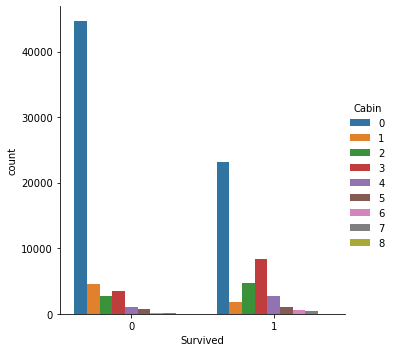

In [316]:
sns.catplot(x='Survived', hue='Cabin', kind='count', data=train_df)
plt.show()

In [ ]:
KNN with k = 220 gave an estimate of = 0.77349.

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

### Submission

In [45]:
predictions_df = pd.DataFrame()
predictions_df['PassengerId'] = test_df.Age.to_dict().keys()
model = make_model('logreg', C=0.46, max_iter=1000).fit(X, y)
predictions_df['Survived'] =  model.predict(test_df)
predictions_df.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')

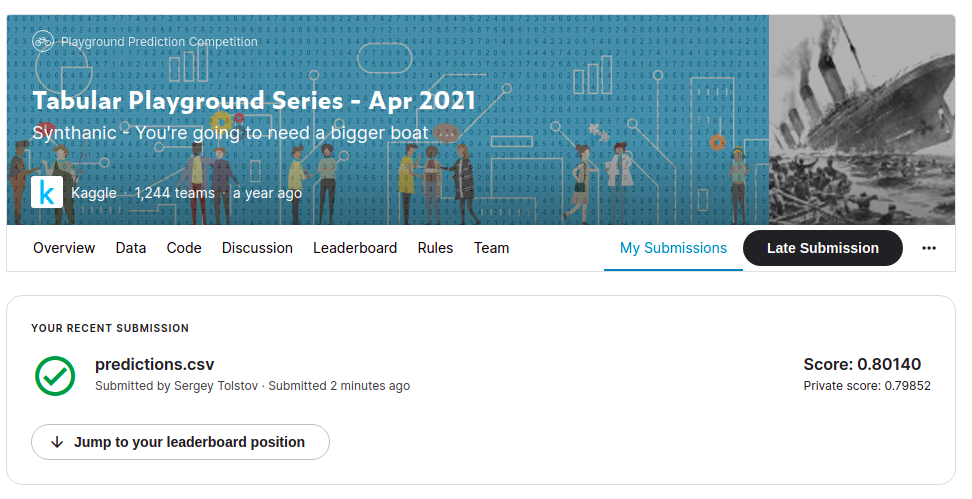